# .........................................................................................   جمع آوری داده های مورد نیاز     

 برای انجام این تحقیق به قیمت های 10 سال گذشته چند کالا (نفت ، طلا ، مس ،شاخص دلار، نقره) احتیاج داشتیم . برای استخراج این داده های مالی منابع مختلف و معتبری مانند : رویترز ، بلومبرگ ، ابزارهای مالی شرکت یاهو و همینطور شرکت گوگل و ..... وجود دارند که می توان از آنها استفاده کرد . ما دراین تحقیق با توجه به اینکه اپ شرکت یاهو  
هماهنگی مناسبی با زبان پایتون دارد ، استفاده از آن را برای استخراج و بارگیری داده ها مفید ارزیابی کرده ایم  

(https://pypi.org/project/yahoofinancials/)

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials

بسته یاهو فایننشیالز به نمادهای تیکر یاهو احتیاج دارد که در قالب یک فایل اکسل آنها را وارد می کنیم و نمادها و نامها را به عنوان لیست های جداگانه استخراج می کنیم 

In [2]:
ticker_details = pd.read_excel("Ticker List.xlsx")
ticker_details.head(20)

,Ticker,Description
0,GC=F,Gold
1,SI=F,Silver
2,CL=F,Crude Oil
3,HG=F,Copper
4,DX=F,Dollar Index


In [3]:
ticker = ticker_details['Ticker'].to_list()
names = ticker_details["Description"].to_list()

حالا که لیست را در اختیار داریم باید مشخص کنیم که داده ها برای چه محدوده تاریخی وارد شوند.در اینجا محدوده بین سالهای 2010 تا 2021 را انتخاب می کنیم و آن را در یک قاب داده خالی می نویسیم ومقادیری که از یاهو استخراج می کنیم در این قاب داده قرار می دهیم  

In [4]:

end_date= "2021-03-01"
start_date = "2010-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
values = pd.DataFrame({ 'Date': date_range})
values['Date']= pd.to_datetime(values['Date'])

با استفاده از یک لوپ قیمت نهایی تاریخها را استخراج کرده و به صورت افقی به قاب داده اضافه می کنیم . با توجه به وجود تعطیلات متفاوت ممکن است فیلدهایی خالی بماند که در نهایت آنها را پر می کنیم

In [5]:

for i in ticker:
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date,"daily")
    df = pd.DataFrame(raw_data[i]["prices"])[['formatted_date','adjclose']]
    df.columns = ['Date1',i]
    df['Date1']= pd.to_datetime(df['Date1'])
    values = values.merge(df,how='left',left_on='Date',right_on='Date1')
    values = values.drop(labels='Date1',axis=1)


names.insert(0,'Date')
values.columns = names
print(values.shape)
print(values.isna().sum())
values.tail()

(2912, 6)
Date              0
Gold            129
Silver          129
Crude Oil       128
Copper          129
Dollar Index    130
dtype: int64


,Date,Gold,Silver,Crude Oil,Copper,Dollar Index
2907,2021-02-23,1804.400024,27.686001,61.669998,4.1875,90.167000
2908,2021-02-24,1796.400024,27.857000,63.220001,4.3010,90.169998
2909,2021-02-25,1774.400024,27.636999,63.529999,4.2660,90.135002
2910,2021-02-26,1728.099976,26.402000,61.500000,4.0945,90.882004
2911,2021-03-01,NaN,NaN,NaN,NaN,NaN


In [6]:
#Front filling the NaN values in the data set
values = values.fillna(method="ffill",axis=0)
values = values.fillna(method="bfill",axis=0)
values.isna().sum()

Date            0
Gold            0
Silver          0
Crude Oil       0
Copper          0
Dollar Index    0
dtype: int64

In [7]:
# Co-ercing numeric type to all columns except Date
cols=values.columns.drop('Date')
values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=1)
values.tail()

,Date,Gold,Silver,Crude Oil,Copper,Dollar Index
2907,2021-02-23,1804.4,27.7,61.7,4.2,90.2
2908,2021-02-24,1796.4,27.9,63.2,4.3,90.2
2909,2021-02-25,1774.4,27.6,63.5,4.3,90.1
2910,2021-02-26,1728.1,26.4,61.5,4.1,90.9
2911,2021-03-01,1728.1,26.4,61.5,4.1,90.9


In [8]:
values.to_csv("Training Data_Values.csv")

در اینجا بازده کوتاه مدت همه ابزارها و بازده بلندمدت آنها را محاسبه می کنیم

In [9]:
imp = ["Gold","Silver", "Crude Oil", "Copper","Dollar Index"]

# Calculating Short term -Historical Returns

change_days = [1,3,5,14,21]

data = pd.DataFrame(data=values['Date'])
for i in change_days:
    print(data.shape)
    x= values[cols].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

# Calculating Long term Historical Returns
change_days = [60,90,180,250]

for i in change_days:
    print(data.shape)
    x= values[imp].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

(2912, 1)
(2912, 6)
(2912, 11)
(2912, 16)
(2912, 21)
(2912, 26)
(2912, 26)
(2912, 31)
(2912, 36)
(2912, 41)
(2912, 46)


میانگین های متحرک یک معیار بسیار متداول تکنیکال در محاسبه نقاط حمایت و مقاومت یک دارایی می باشند .ترکیبی از میانگین های متحرک ساده ونمایی را محاسبه می کنیم و به فضای ویژگی های موجود اضافه می کنیم

In [10]:
moving_avg = pd.DataFrame(values["Date"],columns=["Date"])
moving_avg["Date"]=pd.to_datetime(moving_avg["Date"],format="%Y-%b-%d")
moving_avg["Gold/15SMA"] = (values["Gold"]/(values["Gold"].rolling(window=15).mean()))-1
moving_avg["Gold/30SMA"] = (values["Gold"]/(values["Gold"].rolling(window=30).mean()))-1
moving_avg["Gold/60SMA"] = (values["Gold"]/(values["Gold"].rolling(window=60).mean()))-1
moving_avg["Gold/90SMA"] = (values["Gold"]/(values["Gold"].rolling(window=90).mean()))-1
moving_avg["Gold/180SMA"] = (values["Gold"]/(values["Gold"].rolling(window=180).mean()))-1
moving_avg["Gold/90EMA"] = (values["Gold"]/(values["Gold"].ewm(span=90,adjust=True,ignore_na=True).mean()))-1
moving_avg["Gold/180EMA"] = (values["Gold"]/(values["Gold"].ewm(span=180,adjust=True,ignore_na=True).mean()))-1
moving_avg = moving_avg.dropna(axis=0)
print(moving_avg.shape)
moving_avg.head()

(2733, 8)


,Date,Gold/15SMA,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA
179,2010-09-09,0.005005,0.020246,0.026862,0.026428,0.067496,0.032506,0.046162
180,2010-09-10,0.000536,0.014916,0.023422,0.022489,0.063095,0.028204,0.041912
181,2010-09-13,0.000043,0.013705,0.023840,0.022565,0.062965,0.028040,0.041852
182,2010-09-14,0.017736,0.031368,0.043642,0.042295,0.083187,0.047219,0.061593
183,2010-09-15,0.013857,0.026901,0.040711,0.039604,0.079958,0.043701,0.058291


In [11]:
#Merging Moving Average values to the feature space

print(data.shape)
data["Date"]=pd.to_datetime(data["Date"],format='%Y-%b-%d')
data = pd.merge(left=data,right=moving_avg,how='left',on='Date')
print(data.shape)
data.isna().sum()

(2912, 46)
(2912, 53)


Date                    0
Gold-T-1                1
Silver-T-1              1
Crude Oil-T-1           1
Copper-T-1              1
Dollar Index-T-1        1
Gold-T-3                3
Silver-T-3              3
Crude Oil-T-3           3
Copper-T-3              3
Dollar Index-T-3        3
Gold-T-5                5
Silver-T-5              5
Crude Oil-T-5           5
Copper-T-5              5
Dollar Index-T-5        5
Gold-T-14              14
Silver-T-14            14
Crude Oil-T-14         14
Copper-T-14            14
Dollar Index-T-14      14
Gold-T-21              21
Silver-T-21            21
Crude Oil-T-21         21
Copper-T-21            21
Dollar Index-T-21      21
Gold-T-60              60
Silver-T-60            60
Crude Oil-T-60         60
Copper-T-60            60
Dollar Index-T-60      60
Gold-T-90              90
Silver-T-90            90
Crude Oil-T-90         90
Copper-T-90            90
Dollar Index-T-90      90
Gold-T-180            180
Silver-T-180          180
Crude Oil-T-

اکنون ما باید اهداف ایجاد کنیم ، یعنی آنچه می خواهیم پیش بینی کنیم. افق های 14 روزه و 22 روزه را انتخاب کردم زیرا سایر افق های کوچکتر بسیار ناپایدارو فاقد قدرت پیش بینی هستند. با این حال ، می توان افق های دیگر را نیز آزمایش کرد

In [12]:
y = pd.DataFrame(data=values['Date'])
print(y.shape)
y["Gold-T+14"]=values["Gold"].pct_change(periods=-14)
y["Gold-T+22"]=values["Gold"].pct_change(periods=-22)
print(y.shape)
y.isna().sum()

(2912, 1)
(2912, 3)


Date          0
Gold-T+14    14
Gold-T+22    22
dtype: int64

In [13]:
# Removing NAs

print(data.shape)
data = data[data["Gold-T-250"].notna()]
y = y[y["Gold-T+22"].notna()]
print(data.shape)
print(y.shape)

(2912, 53)
(2662, 53)
(2890, 3)


اکنون ما متغیرهای هدف را با فضای ویژگی ادغام می کنیم تا داده ای دریافت کنیم که در نهایت بتوانیم مدل سازی را شروع کنیم

In [14]:
data = pd.merge(left=data,right=y,how='inner',on='Date',suffixes=(False,False))
print(data.shape)
data.isna().sum()

(2640, 55)


Date                  0
Gold-T-1              0
Silver-T-1            0
Crude Oil-T-1         0
Copper-T-1            0
Dollar Index-T-1      0
Gold-T-3              0
Silver-T-3            0
Crude Oil-T-3         0
Copper-T-3            0
Dollar Index-T-3      0
Gold-T-5              0
Silver-T-5            0
Crude Oil-T-5         0
Copper-T-5            0
Dollar Index-T-5      0
Gold-T-14             0
Silver-T-14           0
Crude Oil-T-14        0
Copper-T-14           0
Dollar Index-T-14     0
Gold-T-21             0
Silver-T-21           0
Crude Oil-T-21        0
Copper-T-21           0
Dollar Index-T-21     0
Gold-T-60             0
Silver-T-60           0
Crude Oil-T-60        0
Copper-T-60           0
Dollar Index-T-60     0
Gold-T-90             0
Silver-T-90           0
Crude Oil-T-90        0
Copper-T-90           0
Dollar Index-T-90     0
Gold-T-180            0
Silver-T-180          0
Crude Oil-T-180       0
Copper-T-180          0
Dollar Index-T-180    0
Gold-T-250      

In [15]:
data.to_csv("Training Data.csv",index=False)

In [16]:
corr = data.corr().iloc[:,-2:].drop(labels=["Gold-T+14","Gold-T+22"],axis=0)

In [17]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

C:\Users\WALL-E\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Gold-T+14', ylabel='Density'>

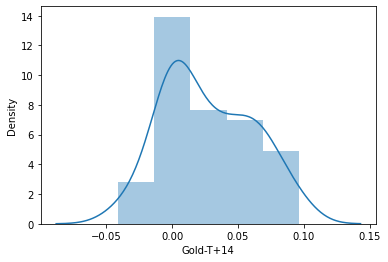

In [18]:
sns.distplot(corr.iloc[:,0])

In [19]:
pd.set_option('display.max_rows', None)
corr_data = data.tail(2000).corr()
corr_data = pd.DataFrame(corr_data['Gold-T+14'])
corr_data = corr_data.sort_values('Gold-T+14',ascending=False)

C:\Users\WALL-E\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

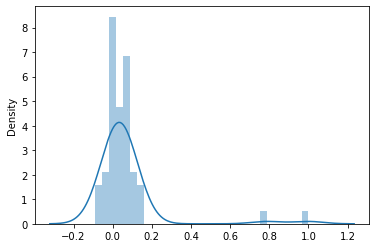

In [20]:
sns.distplot(corr_data)

# Pycaret کتابخانه کارآمد

این کتابخانه یک کتابخانه یادگیری ماشین منبع باز در پایتون است که می تواند در هر محیط نوت بوک مورد استفاده قرار گیرد و مشکلات برنامه نویسی را به شدت کاهش می دهد و این فرآیند را بسیار کارآمد و پربار کند.اکنون مجموعه داده ها برای مدلسازی آماده شده است ، حال با استفاده از این کتابخانه مبتکرانه و کارآمد الگوریتم های مختلف را آزمایش خواهیم کرد

In [21]:
data = pd.read_csv("Training Data.csv")

In [22]:
from pycaret.regression import *

افق 22 روزه را به عنوان هدف در نظر می گیریم. این بدان معناست که با توجه به داده های تاریخی ، ما سعی خواهیم کرد بازده طلا را در سه هفته آینده پیش بینی کنیم

In [23]:
data_22= data.drop(["Gold-T+14"],axis=1)
data_22.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,Copper-T-1,Dollar Index-T-1,Gold-T-3,Silver-T-3,Crude Oil-T-3,Copper-T-3,Dollar Index-T-3,Gold-T-5,Silver-T-5,Crude Oil-T-5,Copper-T-5,Dollar Index-T-5,Gold-T-14,Silver-T-14,Crude Oil-T-14,Copper-T-14,Dollar Index-T-14,Gold-T-21,Silver-T-21,Crude Oil-T-21,Copper-T-21,Dollar Index-T-21,Gold-T-60,Silver-T-60,Crude Oil-T-60,Copper-T-60,Dollar Index-T-60,Gold-T-90,Silver-T-90,Crude Oil-T-90,Copper-T-90,Dollar Index-T-90,Gold-T-180,Silver-T-180,Crude Oil-T-180,Copper-T-180,Dollar Index-T-180,Gold-T-250,Silver-T-250,Crude Oil-T-250,Copper-T-250,Dollar Index-T-250,Gold/15SMA,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA,Gold-T+22
0,2010-12-17,0.005984,0.010417,0.003421,0.02439,0.003727,-0.017811,-0.023490,-0.003398,0.00000,0.013802,-0.004118,0.017483,0.002278,0.02439,0.008739,0.009224,0.073801,0.026838,0.105263,-0.001236,0.018996,0.085821,0.075795,0.105263,0.026684,0.063735,0.359813,0.150327,0.166667,0.015075,0.134744,0.607735,0.167109,0.272727,-0.026506,0.187322,0.590164,0.036514,0.166667,-0.004926,0.233426,0.672414,0.079755,0.235294,0.038560,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0.007675
1,2010-12-20,0.005005,0.006873,0.009091,0.00000,0.002475,0.000000,0.003425,0.002257,0.02439,0.004963,-0.008445,-0.010135,0.002257,0.00000,0.017588,0.000361,0.039007,0.055886,0.105263,-0.003690,0.024627,0.077206,0.089571,0.105263,0.030534,0.068482,0.362791,0.160784,0.166667,0.017588,0.131482,0.592391,0.180851,0.272727,-0.019370,0.192751,0.592391,0.053381,0.166667,0.003717,0.239599,0.683908,0.089571,0.235294,0.041131,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0.011166
2,2010-12-21,0.001949,0.003413,0.011261,0.02381,0.001235,0.012989,0.020833,0.023945,0.04878,0.007453,-0.010972,-0.013423,0.016988,0.02381,0.017566,0.000649,0.035211,0.034562,0.102564,0.003713,0.022464,0.069091,0.099143,0.162162,0.029188,0.062452,0.354839,0.178478,0.194444,0.023990,0.131746,0.580645,0.184697,0.303030,-0.014581,0.204198,0.615385,0.067776,0.194444,0.006203,0.241571,0.651685,0.097800,0.264706,0.042416,-0.002386,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0.030969
3,2010-12-22,-0.001009,0.000000,0.007795,0.00000,0.000000,0.005948,0.010309,0.028409,0.02381,0.003713,0.000938,0.006849,0.021445,0.04878,0.006203,-0.001224,0.031579,0.028409,0.075000,0.009963,0.006751,0.065217,0.114532,0.162162,0.016291,0.059840,0.342466,0.161746,0.162162,0.027883,0.127755,0.597826,0.200265,0.303030,-0.014581,0.196549,0.597826,0.054779,0.194444,0.009963,0.220882,0.615385,0.087740,0.228571,0.043758,-0.003368,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0.034154
4,2010-12-23,-0.004903,-0.003401,0.011050,0.00000,-0.003699,-0.003970,0.000000,0.030405,0.02381,-0.002469,0.007005,0.017361,0.043330,0.04878,0.003727,-0.018073,0.003425,0.025785,0.075000,0.017632,0.005172,0.065455,0.090584,0.131579,0.011264,0.055207,0.344037,0.143750,0.194444,0.024081,0.118496,0.601093,0.229839,0.303030,-0.020606,0.189963,0.592391,0.070175,0.194444,0.002481,0.217898,0.601093,0.106409,0.264706,0.034571,-0.007851,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,0.026404


برای شروع هرگونه تمرین مدل سازی در این کتابخانه ، اولین قدم تابع "راه اندازی" است.  تمام دگرگونی های اولیه و ضروری داده ها مانند رها کردن شناسه ها ، عوامل طبقه بندی شده و محاسبه ارزش از دست رفته به طور خودکار در پشت صحنه اتفاق می افتد.  همچنین بیش از 20 گزینه پیش پردازش را ارائه می دهد

In [24]:
a=setup(data_22,target='Gold-T+22',
        ignore_features=['Date'],session_id=11,
        silent=True,profile=False,remove_outliers=False);

,Description,Value
0,session_id,11
1,Target,Gold-T+22
2,Original Data,"(2640, 54)"
3,Missing Values,False
4,Numeric Features,52
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1847, 52)"


در مرحله بعد ، یکی از ویژگی های جادویی این کتابخانه را به کار می گیریم ، که صدها خط کد را اساساً به 2 کلمه کاهش می دهد . این تابع از همه الگوریتم ها (25 الگوریتم فعلی) استفاده می کند و آنها را با داده ها مطابقت می دهد ، 10 بار اعتبار متقابل را اجرا می کند و 6 معیار ارزیابی را برای هر مدل تفسیر می کند

In [25]:
compare_models(turbo=False)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0113,0.0002,0.0155,0.8779,0.0143,0.9233,1.7510
knn,K Neighbors Regressor,0.0115,0.0002,0.0157,0.8745,0.0137,1.3928,0.0430
lightgbm,Light Gradient Boosting Machine,0.0133,0.0003,0.0178,0.8398,0.0160,1.2786,2.6190
rf,Random Forest Regressor,0.0141,0.0004,0.0192,0.8140,0.0175,1.0757,4.4520
gbr,Gradient Boosting Regressor,0.0202,0.0007,0.0266,0.6443,0.0240,1.5790,1.6160
dt,Decision Tree Regressor,0.0203,0.0010,0.0322,0.4737,0.0220,2.1888,0.0950
mlp,MLP Regressor,0.0278,0.0013,0.0363,0.3382,0.0301,2.0713,0.2640
ada,AdaBoost Regressor,0.0297,0.0014,0.0368,0.3165,0.0321,1.8511,0.5920
ard,Automatic Relevance Determination,0.0314,0.0018,0.0419,0.1184,0.0346,1.8086,0.0650
br,Bayesian Ridge,0.0315,0.0018,0.0420,0.1128,0.0351,1.7790,0.0340


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=11, verbose=0, warm_start=False)

دو الگوریتم نزدیکترین همسایگی و درختان خیلی تصادفی (:  بهترین ضریب تشخیص را دارند ،که چیزی حدود 87% است . حال این دومدل را ایجاد می کنیم (تمرین و تست) 

In [27]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0114,0.0002,0.0158,0.8837,0.0148,0.7775
1,0.0112,0.0003,0.0162,0.8623,0.0146,1.0484
2,0.0110,0.0002,0.0152,0.8644,0.0143,0.6954
3,0.0106,0.0002,0.0145,0.9043,0.0131,1.6381
4,0.0116,0.0002,0.0157,0.8591,0.0144,0.8285
5,0.0116,0.0003,0.0166,0.8839,0.0156,0.7604
6,0.0115,0.0003,0.0159,0.8736,0.0147,1.0817
7,0.0117,0.0003,0.0161,0.8906,0.0147,0.4800
8,0.0113,0.0002,0.0156,0.8692,0.0143,0.9794
9,0.0105,0.0002,0.0139,0.8883,0.0127,0.9432


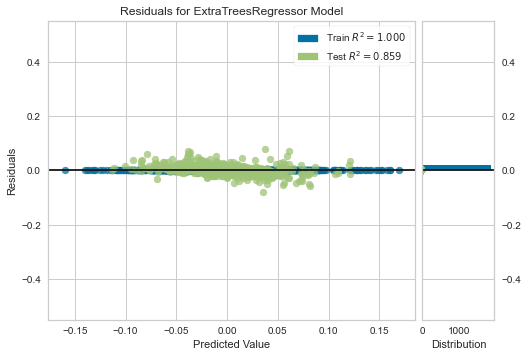

In [30]:
plot_model(et)

In [31]:
knn = create_model('knn')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0116,0.0002,0.0150,0.8950,0.0138,1.2314
1,0.0118,0.0002,0.0157,0.8708,0.0135,0.9529
2,0.0115,0.0002,0.0155,0.8596,0.0136,1.1052
3,0.0112,0.0002,0.0148,0.9006,0.0130,2.1509
4,0.0117,0.0003,0.0174,0.8276,0.0135,1.0266
5,0.0109,0.0002,0.0150,0.9046,0.0127,0.8315
6,0.0117,0.0003,0.0160,0.8713,0.0144,1.5037
7,0.0119,0.0003,0.0169,0.8787,0.0148,0.7853
8,0.0117,0.0002,0.0155,0.8719,0.0134,2.8414
9,0.0106,0.0002,0.0153,0.8650,0.0139,1.4991


In [32]:
tuned_knn = tune_model(knn, n_iter = 150)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0103,0.0002,0.0141,0.9078,0.0127,1.5535
1,0.0091,0.0002,0.0130,0.9110,0.0121,1.2308
2,0.0089,0.0001,0.0120,0.9160,0.0108,1.1162
3,0.0100,0.0002,0.0147,0.9018,0.0132,1.7616
4,0.0101,0.0002,0.0149,0.8739,0.0131,1.1096
5,0.0101,0.0002,0.0134,0.9241,0.0121,0.7709
6,0.0091,0.0001,0.0120,0.9276,0.0105,0.9657
7,0.0097,0.0002,0.0142,0.9139,0.0129,0.6042
8,0.0105,0.0002,0.0141,0.8931,0.0117,1.7539
9,0.0082,0.0001,0.0117,0.9211,0.0107,0.9376


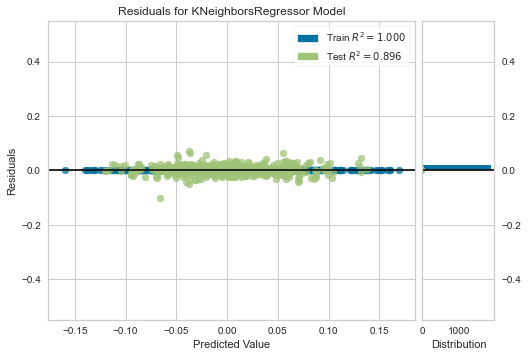

In [34]:
plot_model(tuned_knn)


همانطور که در بالا می بینید الگوریتم نزدیکترین همسایگی پس از تیونینگ به میزان قابل توجهی(90.9%) بهبود یافت

انجام برخی ازفرایندهای تشخیص بر روی مدلهای آموزش دیده بسیار مهم است. ما فرایند تشخیص و مشاهده مجموعه نمودارها  را در هر دو مدل برتر خود انجام می دهیم

In [44]:
evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [45]:
evaluate_model(tuned_knn)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

حال با استفاده از ترکیب این دو مدل سعی می کنیم عملکرد مدل را ارتقا دهیم

In [46]:
blend_knn_et = blend_models(estimator_list=[tuned_knn,et])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0101,0.0002,0.0135,0.9150,0.0125,1.1158
1,0.0092,0.0002,0.0134,0.9054,0.0124,0.8017
2,0.0090,0.0001,0.0120,0.9149,0.0113,0.8494
3,0.0092,0.0002,0.0129,0.9239,0.0116,1.1731
4,0.0099,0.0002,0.0138,0.8914,0.0124,0.9274
5,0.0099,0.0002,0.0132,0.9257,0.0122,0.7293
6,0.0097,0.0002,0.0128,0.9181,0.0115,0.9451
7,0.0093,0.0002,0.0135,0.9231,0.0122,0.4615
8,0.0095,0.0002,0.0129,0.9106,0.0113,1.0545
9,0.0083,0.0001,0.0113,0.9259,0.0103,0.8094


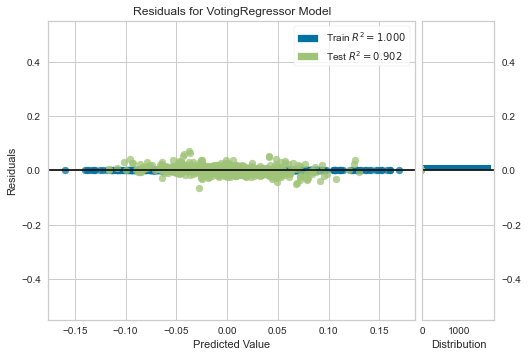

In [47]:
plot_model(blend_knn_et)

In [48]:
evaluate_model(blend_knn_et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [49]:
save_model(model=blend_knn_et, model_name='22 Rooze Ayande')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['Date'], id_columns=[],
                                       ml_usecase='regression',
                                       numerical_features=[], target='Gold-T+22',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric...
                                                                   ccp_alpha=0.0,
                                                                   criterion='mse',
                                                                   max_depth=None,
                         

In [50]:
data_14= data.drop(['Gold-T+22'],axis=1)
data_14.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,Copper-T-1,Dollar Index-T-1,Gold-T-3,Silver-T-3,Crude Oil-T-3,Copper-T-3,...,Copper-T-250,Dollar Index-T-250,Gold/15SMA,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA,Gold-T+14
0,2010-12-17,0.005984,0.010417,0.003421,0.02439,0.003727,-0.017811,-0.023490,-0.003398,0.00000,...,0.235294,0.038560,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0.005250
1,2010-12-20,0.005005,0.006873,0.009091,0.00000,0.002475,0.000000,0.003425,0.002257,0.02439,...,0.235294,0.041131,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0.012422
2,2010-12-21,0.001949,0.003413,0.011261,0.02381,0.001235,0.012989,0.020833,0.023945,0.04878,...,0.264706,0.042416,-0.002386,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0.010555
3,2010-12-22,-0.001009,0.000000,0.007795,0.00000,0.000000,0.005948,0.010309,0.028409,0.02381,...,0.228571,0.043758,-0.003368,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0.002023
4,2010-12-23,-0.004903,-0.003401,0.011050,0.00000,-0.003699,-0.003970,0.000000,0.030405,0.02381,...,0.264706,0.034571,-0.007851,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,-0.004113


In [51]:
c=setup(data_14,target='Gold-T+14',
        ignore_features=['Date'],session_id=11,
        silent=True,profile=False,remove_outliers=True);

,Description,Value
0,session_id,11
1,Target,Gold-T+14
2,Original Data,"(2640, 54)"
3,Missing Values,False
4,Numeric Features,52
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1754, 52)"


In [52]:
compare_models(turbo=False)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0113,0.0002,0.0155,0.8085,0.0143,1.0963,1.7000
knn,K Neighbors Regressor,0.0113,0.0002,0.0155,0.8067,0.0135,1.6199,0.0480
lightgbm,Light Gradient Boosting Machine,0.0130,0.0003,0.0177,0.7497,0.0157,1.7358,2.9030
rf,Random Forest Regressor,0.0142,0.0004,0.0197,0.6915,0.0179,1.2452,4.3770
gbr,Gradient Boosting Regressor,0.0189,0.0006,0.0248,0.5110,0.0225,1.5634,1.4970
dt,Decision Tree Regressor,0.0190,0.0008,0.0289,0.3365,0.0204,2.5922,0.1100
ada,AdaBoost Regressor,0.0245,0.0010,0.0309,0.2424,0.0275,1.5778,0.6220
mlp,MLP Regressor,0.0238,0.0010,0.0315,0.2156,0.0255,2.0620,0.2750
ard,Automatic Relevance Determination,0.0253,0.0012,0.0340,0.0879,0.0284,1.8206,0.0650
lr,Linear Regression,0.0255,0.0012,0.0342,0.0799,0.0280,1.9447,8.3850


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=11, verbose=0, warm_start=False)

In [53]:
knn = create_model('knn')
tuned_knn = tune_model(knn,n_iter=150)
et = create_model('et')
blend_knn_et = blend_models(estimator_list=[tuned_knn,et])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0105,0.0002,0.0142,0.8690,0.0131,1.9205
1,0.0083,0.0001,0.0115,0.9011,0.0107,0.8079
2,0.0084,0.0001,0.0114,0.8787,0.0104,0.8230
3,0.0106,0.0002,0.0142,0.8655,0.0128,1.7274
4,0.0092,0.0002,0.0141,0.7834,0.0119,0.8852
5,0.0083,0.0001,0.0113,0.9114,0.0104,0.9960
6,0.0096,0.0002,0.0125,0.8673,0.0114,0.8292
7,0.0096,0.0002,0.0127,0.8896,0.0118,1.9644
8,0.0093,0.0002,0.0129,0.8625,0.0117,1.2676
9,0.0099,0.0002,0.0140,0.8277,0.0118,0.8265


In [54]:
save_model(model=blend_knn_et, model_name='14 Rooze Ayande')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['Date'], id_columns=[],
                                       ml_usecase='regression',
                                       numerical_features=[], target='Gold-T+14',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric...
                                                                   ccp_alpha=0.0,
                                                                   criterion='mse',
                                                                   max_depth=None,
                         

هنگامی که مدل های خود را ذخیره کردیم ، می خواهیم پیش از آنکه داده های جدید وارد شوند ، پیش بینی کنیم. ما می توانیم به بسته مالی یاهو اعتماد کنیم تا قیمت نهایی همه ابزارها را به ما ارائه دهد ، با این حال ، ما باید داده های جدید را دوباره آماده کنیم تا بتوانیم از مدل استفاده کنیم

In [55]:
#Importing Libraries

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
ticker_details = pd.read_excel("Ticker List.xlsx")
ticker = ticker_details['Ticker'].to_list()
names = ticker_details["Description"].to_list()

#Preparing Date Range

end_date= datetime.strftime(datetime.today(),'%Y-%m-%d')
start_date = "2019-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
values = pd.DataFrame({ 'Date': date_range})
values['Date']= pd.to_datetime(values['Date'])

#Extracting Data from Yahoo Finance and Adding them to Values table using date as key

for i in ticker:
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
    df = pd.DataFrame(raw_data[i]["prices"])[['formatted_date','adjclose']]
    df.columns = ['Date1',i]
    df['Date1']= pd.to_datetime(df['Date1'])
    values = values.merge(df,how='left',left_on='Date',right_on='Date1')
    values = values.drop(labels='Date1',axis=1)
    
#Renaming columns to represent instrument names rather than their ticker codes for ease of readability

names.insert(0,'Date')
values.columns = names

#Front filling the NaN values in the data set

values = values.fillna(method="ffill",axis=0)
values = values.fillna(method="bfill",axis=0)

# Co-ercing numeric type to all columns except Date

cols=values.columns.drop('Date')
values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=1)
imp = ["Gold","Silver", "Crude Oil", "Copper","Dollar Index"]

# Calculating Short term -Historical Returns

change_days = [1,3,5,14,21]
data = pd.DataFrame(data=values['Date'])
for i in change_days:
    x= values[cols].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
    
# Calculating Long term Historical Returns

change_days = [60,90,180,250]
for i in change_days:
    x= values[imp].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
#Calculating Moving averages for Gold

moving_avg = pd.DataFrame(values['Date'],columns=['Date'])
moving_avg['Date']=pd.to_datetime(moving_avg['Date'],format='%Y-%b-%d')
moving_avg['Gold/15SMA'] = (values['Gold']/(values['Gold'].rolling(window=15).mean()))-1
moving_avg['Gold/30SMA'] = (values['Gold']/(values['Gold'].rolling(window=30).mean()))-1
moving_avg['Gold/60SMA'] = (values['Gold']/(values['Gold'].rolling(window=60).mean()))-1
moving_avg['Gold/90SMA'] = (values['Gold']/(values['Gold'].rolling(window=90).mean()))-1
moving_avg['Gold/180SMA'] = (values['Gold']/(values['Gold'].rolling(window=180).mean()))-1
moving_avg['Gold/90EMA'] = (values['Gold']/(values['Gold'].ewm(span=90,adjust=True,ignore_na=True).mean()))-1
moving_avg['Gold/180EMA'] = (values['Gold']/(values['Gold'].ewm(span=180,adjust=True,ignore_na=True).mean()))-1
moving_avg = moving_avg.dropna(axis=0)

#Merging Moving Average values to the feature space

data['Date']=pd.to_datetime(data['Date'],format='%Y-%b-%d')
data = pd.merge(left=data,right=moving_avg,how='left',on='Date')
data = data[data['Gold-T-250'].notna()]
prediction_data = data.copy()

پس از آماده سازی داده ها ، باید مدل را بارگذاری کرده و پیش بینی کنیم.کدهای زیر مدل را بارگذاری می کند و داده های جدید را پیش بینی می کند  

In [56]:
from pycaret.regression import *

#Loading the stored model

regressor_22 = load_model("22 Rooze Ayande");

#Making Predictions

predicted_return_22 = predict_model(regressor_22,data=prediction_data)
predicted_return_22=predicted_return_22[['Date','Label']]
predicted_return_22.columns = ['Date','Return_22']

#Adding return Predictions to Gold Values

predicted_values = values[['Date','Gold']]
predicted_values = predicted_values.tail(len(predicted_return_22))
predicted_values = pd.merge(left=predicted_values,right=predicted_return_22,on=['Date'],how='inner')
predicted_values['Gold-T+22']=(predicted_values['Gold']*(1+predicted_values['Return_22'])).round(decimals =1)

#Adding T+22 Date

from datetime import datetime, timedelta
predicted_values['Date-T+22'] = predicted_values['Date']+timedelta(days = 22)
predicted_values.tail()

Transformation Pipeline and Model Successfully Loaded


,Date,Gold,Return_22,Gold-T+22,Date-T+22
460,2021-09-21,1776.0,0.015065,1802.8,2021-10-13
461,2021-09-22,1776.7,-0.010876,1757.4,2021-10-14
462,2021-09-23,1747.7,-0.016562,1718.8,2021-10-15
463,2021-09-24,1749.7,-0.013728,1725.7,2021-10-16
464,2021-09-27,1749.7,-0.015106,1723.3,2021-10-19


In [57]:
from pycaret.regression import *

#Loading the stored model

regressor_14 = load_model("14 Rooze Ayande");

#Making Predictions

predicted_return_14 = predict_model(regressor_14,data=prediction_data)
predicted_return_14=predicted_return_14[['Date','Label']]
predicted_return_14.columns = ['Date','Return_14']

#Adding return Predictions to Gold Values

predicted_values = values[['Date','Gold']]
predicted_values = predicted_values.tail(len(predicted_return_14))
predicted_values = pd.merge(left=predicted_values,right=predicted_return_14,on=['Date'],how='inner')
predicted_values['Gold-T+14']=(predicted_values['Gold']*(1+predicted_values['Return_14'])).round(decimals =1)

#Adding T+14 Date

from datetime import datetime, timedelta
predicted_values['Date-T+14'] = predicted_values['Date']+timedelta(days = 14)
predicted_values.tail()

Transformation Pipeline and Model Successfully Loaded


,Date,Gold,Return_14,Gold-T+14,Date-T+14
460,2021-09-21,1776.0,0.000971,1777.7,2021-10-05
461,2021-09-22,1776.7,-0.000197,1776.3,2021-10-06
462,2021-09-23,1747.7,0.000752,1749.0,2021-10-07
463,2021-09-24,1749.7,-0.000710,1748.5,2021-10-08
464,2021-09-27,1749.7,-0.000660,1748.5,2021-10-11


لطفاً توجه داشته باشید که بازار طلا یک بازار بسیار رقابتی است. کسب درآمد مداوم از هر استراتژی برای مدت طولانی اگر غیرممکن نباشد ، بسیار دشوار است. این مقاله فقط برای  انجام پروژه پایانی دوره کارشناسی فناوری اطلاعات است و نه ایده ای برای سرمایه گذاری یا تجارت. با این حال ، برای دانشجویانی مانند من ، این ایده را می توان توسعه داد و با تلاش های فردی به الگوریتم های تجاری تبدیل کرد